In [1]:
import sys
sys.executable

'/usr/bin/python3.6'

In [32]:
import librosa
import numpy as np
import os
import scipy.io.wavfile as sio

more_cleans = [x for x in sorted(os.listdir("data-lite")) if x.endswith("-clean.wav")][:2]
more_noisy = [x for x in sorted(os.listdir("data-lite")) if not x.endswith("-clean.wav")][:2]

time = [sio.read("data-lite/" + x)[1].astype(np.float32) / 2**15 for x in more_cleans]
time = [(-1 * np.log(np.abs(librosa.stft(x[:, 0], n_fft=512, hop_length=128).T) ** 2 + 2e-12)).shape[0] for x in time]
maxtime, howmuch = max(time), (len(time) * 8)

cleans = np.zeros([howmuch, maxtime, 257], np.float32)
noisy = np.zeros([howmuch, maxtime, 257], np.float32)

cnt = 0

for nname, cname in zip(more_noisy, more_cleans):
    this_clean = sio.read("data-lite/" + cname)[1].astype(np.float32) / 2**15
    this_noisy = sio.read("data-lite/" + nname)[1].astype(np.float32) / 2**15
    for channel in range(this_clean.shape[1]):
        X = -1 * np.log(np.abs(librosa.stft(this_clean[:, channel], n_fft=512, hop_length=128).T) ** 2 + 2e-12)
        cleans[cnt, :X.shape[0]] = X
        X = -1 * np.log(np.abs(librosa.stft(this_noisy[:, channel], n_fft=512, hop_length=128).T) ** 2 + 2e-12)
        noisy[cnt, :X.shape[0]] = X
        cnt += 1



(16, 1944, 257) 1732
(16, 1944, 257) 1732
(16, 1944, 257) 1732
(16, 1944, 257) 1732
(16, 1944, 257) 1732
(16, 1944, 257) 1732
(16, 1944, 257) 1732
(16, 1944, 257) 1732
(16, 1944, 257) 1944
(16, 1944, 257) 1944
(16, 1944, 257) 1944
(16, 1944, 257) 1944
(16, 1944, 257) 1944
(16, 1944, 257) 1944
(16, 1944, 257) 1944
(16, 1944, 257) 1944


In [33]:
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.layers import Input, Lambda, LeakyReLU, Conv2D, TimeDistributed, \
    Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import L1L2
import librosa
import numpy as np
import random

from utils import list_sounds, open_sound


def mk_model():
    input_lower = Input((None, 257), name="input_lf")
    layer = Lambda(K.expand_dims)(input_lower)
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(9, 1), activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(1, 5), activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(9, 1), activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(1, 5), activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(2048, kernel_regularizer=L1L2(l1=1e-6, l2=1e-6))(layer))
    layer = LeakyReLU(0.01, name='hidden')(Dense(1024, kernel_regularizer=L1L2(l1=1e-6, l2=1e-6))(layer))
    layer = LeakyReLU(0.01)(Dense(512, kernel_regularizer=L1L2(l1=1e-6, l2=1e-6))(layer))
    layer = Dense(257)(layer)
    layer = LeakyReLU(0.01)(layer)
    mdl = Model(input_lower, layer)
    return mdl


class StopOnConvergence(Callback):
    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions

    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf

    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True

model = mk_model()
model.compile(keras.optimizers.Adam(2e-4, clipnorm=1.), 'mse') 
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 257)         0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 257, 1)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, 257, 32)     320       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, None, 257, 32)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, 253, 32)     5152      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, None, 253, 32)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, 253, 32)     9248      
__________

In [34]:
# TODO: train on proper noisy ones
model.fit(noisy[1:], cleans[1:, 16:], epochs=25, batch_size=32, validation_data=[noisy[:1], cleans[:1, 16:]])

Train on 15 samples, validate on 1 samples
Epoch 1/1
15/15 [==============================] - 81s 5s/step - loss: 52.0820 - val_loss: 34.8018


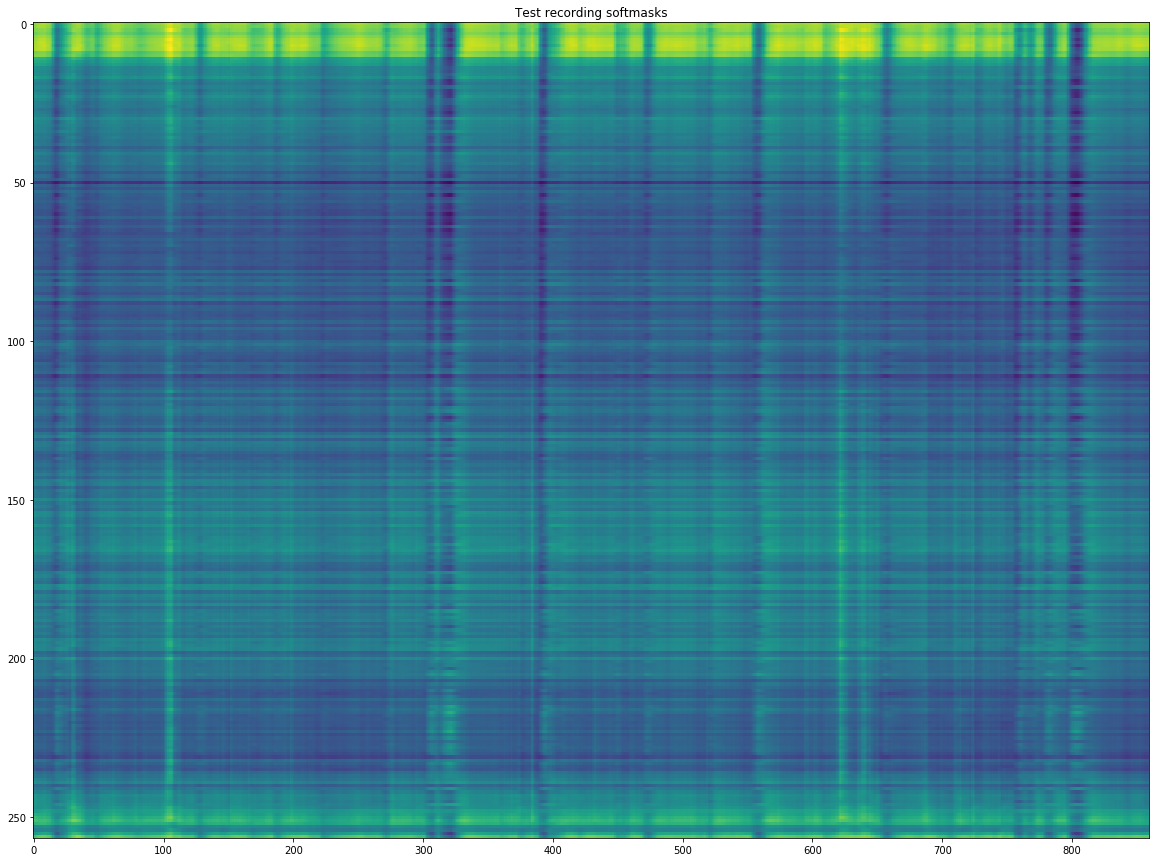

In [24]:
import matplotlib.pyplot as plt
a = model.predict(noisy[5081:5082])[0]
plt.figure(figsize=(20,15))
plt.imshow(np.flip(-1 * a.T[:, 230:], 0), aspect='auto')
plt.title("Test recording softmasks")
plt.show()